# STEP 1 — Load & Basic Quality Checks

In [1]:


# Install dependencies
!pip install -q pandas openpyxl numpy

import pandas as pd
import numpy as np
from pathlib import Path

# Locate and read the Excel file
'''
CANDIDATES = [
    Path("/content/Overall_dataset_noninvasive.xlsx"),
    Path("Overall_dataset_noninvasive.xlsx"),
]


from google.colab import drive
drive.mount('/content/drive')
CANDIDATES = pd.read_excel('Overall_dataset_noninvasive.xlsx')
# excel file "Overall_dataset_noninvasive.xlsx" should be uploaded in google drive and this colab notebook

'''
from google.colab import drive
drive.mount('/content/drive')

# DO NOT read Excel here
# Instead, define file candidates
CANDIDATES = [
    Path("/content/drive/MyDrive/Overall_dataset_noninvasive.xlsx"),  # if file is in Drive
    Path("/content/Overall_dataset_noninvasive.xlsx"),
    Path("Overall_dataset_noninvasive.xlsx"),
]

FILE_PATH = None
for p in CANDIDATES:
    if p.exists():
        FILE_PATH = str(p)
        break




if FILE_PATH is None:
    raise FileNotFoundError(
        "Excel file not found. Please place 'Overall_dataset_noninvasive.xlsx' in /content or current working directory."
    )

xls = pd.ExcelFile(FILE_PATH)
sheet_name = "Sheet1" if "Sheet1" in xls.sheet_names else xls.sheet_names[0]
df = pd.read_excel(FILE_PATH, sheet_name=sheet_name)

#Normalize column names
df.columns = [c.strip() for c in df.columns]

#Verify required columns
required_cols = {
    "CaseID", "Status", "Gestational_Age", "Maternal_Age",
    "PI_MCA", "PI_UA", "PI_MCA_UA"
}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

#Remove duplicates
n_before = len(df)
df = df.drop_duplicates()
n_after = len(df)
if n_after < n_before:
    print(f"Removed {n_before - n_after} duplicate rows.")

#Standardize 'Status' labels
df["Status"] = (
    df["Status"]
    .astype(str)
    .str.strip()
    .str.upper()
    .map({"IUGR": "IUGR", "NORMAL": "Normal"})
)

if df["Status"].isna().any():
    bad_idx = df["Status"].isna()
    bad_vals = pd.Series(df.loc[bad_idx, "Status"]).astype(str).unique().tolist()
    raise ValueError(
        f"Unrecognized labels found in 'Status'. Please ensure only 'IUGR' or 'Normal'. Problematic values: {bad_vals}"
    )

# Enforce numeric dtypes
numeric_cols = ["Gestational_Age", "Maternal_Age", "PI_MCA", "PI_UA", "PI_MCA_UA"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Check for NaNs after conversion
if df[numeric_cols].isnull().any().any():
    nan_report = df[numeric_cols].isnull().sum()
    print("NaNs detected after numeric conversion:")
    print(nan_report)
    raise ValueError("NaN values detected in numeric columns after coercion. Please fix source data.")

# Quality summary
print("\n=== DATA QUALITY SUMMARY ===")
print(f"File path: {FILE_PATH}")
print(f"Sheet used: {sheet_name}")
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nStatus distribution:\n", df["Status"].value_counts())
print("\nFirst 5 rows:")
display(df.head())


Mounted at /content/drive

=== DATA QUALITY SUMMARY ===
File path: /content/drive/MyDrive/Overall_dataset_noninvasive.xlsx
Sheet used: Sheet1
Shape: (400, 7)

Dtypes:
 CaseID               int64
Status              object
Gestational_Age      int64
Maternal_Age         int64
PI_MCA             float64
PI_UA              float64
PI_MCA_UA          float64
dtype: object

Missing values per column:
 CaseID             0
Status             0
Gestational_Age    0
Maternal_Age       0
PI_MCA             0
PI_UA              0
PI_MCA_UA          0
dtype: int64

Status distribution:
 Status
IUGR      200
Normal    200
Name: count, dtype: int64

First 5 rows:


,CaseID,Status,Gestational_Age,Maternal_Age,PI_MCA,PI_UA,PI_MCA_UA
0,1,IUGR,32,28,1.2,1.8,0.67
1,2,IUGR,34,31,1.1,1.9,0.58
2,3,IUGR,36,25,1.3,1.7,0.76
3,4,IUGR,28,29,0.9,2.1,0.43
4,5,IUGR,37,33,1.4,1.6,0.88


# STEP 2 — Feature Engineering & Final Dataset Construction

In [2]:
#  Create engineered features
df["PI_Diff"] = df["PI_MCA"] - df["PI_UA"]
df["PI_MCA_UA_Product"] = df["PI_MCA"] * df["PI_UA"]
df["GA_MCA_Interaction"] = df["Gestational_Age"] * df["PI_MCA"]
df["UA_Adjusted"] = df["PI_UA"] / df["Gestational_Age"]

# Select original + engineered features
original_features = ["Gestational_Age", "Maternal_Age", "PI_MCA", "PI_UA", "PI_MCA_UA"]
engineered_features = ["PI_Diff", "PI_MCA_UA_Product", "GA_MCA_Interaction", "UA_Adjusted"]

final_features = original_features + engineered_features
final_dataset = df[final_features + ["Status"]]

# Shuffle rows randomly
final_dataset = final_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Summary of final dataset
print("\n=== FINAL DATASET SUMMARY ===")
print("Shape:", final_dataset.shape)
print("\nColumns:\n", final_dataset.columns.tolist())
print("\nClass distribution:\n", final_dataset["Status"].value_counts())
print("\nFirst 5 rows (shuffled):")
display(final_dataset.head())



=== FINAL DATASET SUMMARY ===
Shape: (400, 10)

Columns:
 ['Gestational_Age', 'Maternal_Age', 'PI_MCA', 'PI_UA', 'PI_MCA_UA', 'PI_Diff', 'PI_MCA_UA_Product', 'GA_MCA_Interaction', 'UA_Adjusted', 'Status']

Class distribution:
 Status
Normal    200
IUGR      200
Name: count, dtype: int64

First 5 rows (shuffled):


,Gestational_Age,Maternal_Age,PI_MCA,PI_UA,PI_MCA_UA,PI_Diff,PI_MCA_UA_Product,GA_MCA_Interaction,UA_Adjusted,Status
0,36,31,1.1,1.6,1.45,-0.5,1.76,39.6,0.044444,Normal
1,37,34,0.8,2.0,2.50,-1.2,1.60,29.6,0.054054,Normal
2,34,31,1.2,1.7,0.71,-0.5,2.04,40.8,0.050000,IUGR
3,38,28,0.9,1.9,2.11,-1.0,1.71,34.2,0.050000,Normal
4,33,30,1.1,1.8,0.61,-0.7,1.98,36.3,0.054545,IUGR


## TABLE 1: Summary statistics by class (IUGR vs Normal)

 *    Works if you already loaded your dataframe as `df`
*    Otherwise it will try to read "Overall_dataset_noninvasive.xlsx"
*    Produces descriptive stats per class + group-difference tests
*    Saves to: table1_summary_by_class.csv










In [3]:

import os
import numpy as np
import pandas as pd
from scipy import stats

#  Load df if not already in memory
if "df" not in globals():
    data_path = "Overall_dataset_noninvasive.xlsx"
    assert os.path.exists(data_path), f"Dataset not found at: {data_path}"
    df = pd.read_excel(data_path)

# Detect label column
possible_label_cols = ["Status", "Label", "Target", "Outcome", "Hypoxia", "IUGR"]
label_col = next((c for c in possible_label_cols if c in df.columns), None)
if label_col is None:
    raise ValueError(f"Could not find a label column among: {possible_label_cols}. "
                     f"Available columns: {list(df.columns)}")

#  Map label to binary 0/1 (0=Normal, 1=IUGR)
def to_binary_series(s: pd.Series) -> pd.Series:
    if s.dtype.kind in "ifb":
        uniq = pd.unique(s.dropna())
        if set(uniq).issubset({0,1}):
            return s.astype(int)
        # Fallback numeric binarization (not ideal; update if needed)
        thresh = np.nanmedian(s)
        return (s > thresh).astype(int)
    s2 = s.astype(str).str.lower().str.strip()
    pos = {"iugr","1","true","yes","hypoxia","case","positive","pos"}
    neg = {"normal","0","false","no","control","negative","neg"}
    out = []
    for v in s2:
        if v in pos: out.append(1)
        elif v in neg: out.append(0)
        else: out.append(np.nan)
    out = pd.Series(out, index=s.index)
    if out.isna().mean() < 0.5:
        mode_val = int(out.dropna().mode().iloc[0])
        return out.fillna(mode_val).astype(int)
    uniques = s.unique()
    if len(uniques) == 2:
        mapping = {uniques[0]:0, uniques[1]:1}
        return s.map(mapping).astype(int)
    raise ValueError("Could not map label to 0/1. Please convert label manually.")

y = to_binary_series(df[label_col].copy())

# We keep all numeric features except obvious ID columns and the label
id_cols = [c for c in df.columns if any(tok in c.lower() for tok in ["id", "case", "patient"])]
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_cols + [label_col]]

# Build a working frame
work = df.copy()
work["_y_"] = y

#  Helper functions
def iqr(x):
    q75, q25 = np.nanpercentile(x, 75), np.nanpercentile(x, 25)
    return q75 - q25

def cohens_d(x, y):
    # Cohen's d for two independent samples
    x = pd.Series(x).dropna().values
    y = pd.Series(y).dropna().values
    if len(x) < 2 or len(y) < 2:
        return np.nan
    nx, ny = len(x), len(y)
    sx, sy = np.nanstd(x, ddof=1), np.nanstd(y, ddof=1)
    # pooled SD
    s_p = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx + ny - 2)) if (nx+ny-2) > 0 else np.nan
    if s_p == 0 or np.isnan(s_p):
        return np.nan
    return (np.nanmean(x) - np.nanmean(y)) / s_p

def safe_ttest(x, y):
    try:
        return stats.ttest_ind(pd.Series(x).dropna(), pd.Series(y).dropna(), equal_var=False, nan_policy='omit').pvalue
    except Exception:
        return np.nan

def safe_mwu(x, y):
    try:
        # Use two-sided Mann-Whitney U
        return stats.mannwhitneyu(pd.Series(x).dropna(), pd.Series(y).dropna(), alternative='two-sided').pvalue
    except Exception:
        return np.nan

#  Build Table 1
rows = []
for col in num_cols:
    g0 = work.loc[work["_y_"] == 0, col]  # Normal
    g1 = work.loc[work["_y_"] == 1, col]  # IUGR

    row = {
        "Feature": col,
        "N (Normal)": int(g0.notna().sum()),
        "Mean (Normal)": float(np.nanmean(g0)),
        "SD (Normal)": float(np.nanstd(g0, ddof=1)) if g0.notna().sum() > 1 else np.nan,
        "Median (Normal)": float(np.nanmedian(g0)),
        "IQR (Normal)": float(iqr(g0)),
        "Min (Normal)": float(np.nanmin(g0)),
        "Max (Normal)": float(np.nanmax(g0)),

        "N (IUGR)": int(g1.notna().sum()),
        "Mean (IUGR)": float(np.nanmean(g1)),
        "SD (IUGR)": float(np.nanstd(g1, ddof=1)) if g1.notna().sum() > 1 else np.nan,
        "Median (IUGR)": float(np.nanmedian(g1)),
        "IQR (IUGR)": float(iqr(g1)),
        "Min (IUGR)": float(np.nanmin(g1)),
        "Max (IUGR)": float(np.nanmax(g1)),

        "Missing (Total)": int(work[col].isna().sum()),
        # Group-difference tests:
        "p (t-test)": safe_ttest(g1, g0),          # IUGR vs Normal
        "p (Mann–Whitney)": safe_mwu(g1, g0),
        "Cohen's d": cohens_d(g1, g0)
    }
    rows.append(row)

table1 = pd.DataFrame(rows)

# Pretty order
ordered_cols = [
    "Feature",
    "N (Normal)", "Mean (Normal)", "SD (Normal)", "Median (Normal)", "IQR (Normal)", "Min (Normal)", "Max (Normal)",
    "N (IUGR)",   "Mean (IUGR)",   "SD (IUGR)",   "Median (IUGR)",   "IQR (IUGR)",   "Min (IUGR)",   "Max (IUGR)",
    "Missing (Total)", "p (t-test)", "p (Mann–Whitney)", "Cohen's d"
]
table1 = table1[ordered_cols]

# Display and save
pd.set_option("display.max_rows", None)
try:
    from IPython.display import display
    display(table1.style.format({
        "Mean (Normal)": "{:.3f}", "SD (Normal)": "{:.3f}",
        "Median (Normal)": "{:.3f}", "IQR (Normal)": "{:.3f}",
        "Min (Normal)": "{:.3f}", "Max (Normal)": "{:.3f}",
        "Mean (IUGR)": "{:.3f}", "SD (IUGR)": "{:.3f}",
        "Median (IUGR)": "{:.3f}", "IQR (IUGR)": "{:.3f}",
        "Min (IUGR)": "{:.3f}", "Max (IUGR)": "{:.3f}",
        "p (t-test)": "{:.4f}", "p (Mann–Whitney)": "{:.4f}",
        "Cohen's d": "{:.3f}"
    }))
except:
    print(table1)

out_csv = "table1_summary_by_class.csv"
table1.to_csv(out_csv, index=False)
print(f"Saved Table 1 to: {out_csv}")


,Feature,N (Normal),Mean (Normal),SD (Normal),Median (Normal),IQR (Normal),Min (Normal),Max (Normal),N (IUGR),Mean (IUGR),SD (IUGR),Median (IUGR),IQR (IUGR),Min (IUGR),Max (IUGR),Missing (Total),p (t-test),p (Mann–Whitney),Cohen's d
0,Gestational_Age,200,37.320,1.275,37.000,2.000,35.000,40.000,200,33.930,3.158,34.000,5.000,28.000,40.000,0,0.0000,0.0000,-1.408
1,Maternal_Age,200,32.880,3.757,32.000,6.000,26.000,40.000,200,29.980,2.923,30.000,4.500,25.000,35.000,0,0.0000,0.0000,-0.862
2,PI_MCA,200,1.036,0.198,1.000,0.300,0.700,1.400,200,1.155,0.252,1.200,0.300,0.700,1.700,0,0.0000,0.0000,0.523
3,PI_UA,200,1.689,0.231,1.700,0.400,1.300,2.100,200,1.760,0.267,1.700,0.300,1.200,2.300,0,0.0047,0.0070,0.284
4,PI_MCA_UA,200,1.738,0.588,1.700,0.860,0.930,3.000,200,0.694,0.257,0.710,0.280,0.300,1.420,0,0.0000,0.0000,-2.301
5,PI_Diff,200,-0.652,0.429,-0.700,0.700,-1.400,0.100,200,-0.605,0.517,-0.500,0.600,-1.600,0.500,0,0.3180,0.2831,0.100
6,PI_MCA_UA_Product,200,1.705,0.103,1.710,0.180,1.470,1.820,200,1.967,0.160,2.040,0.180,1.540,2.250,0,0.0000,0.0000,1.943
7,GA_MCA_Interaction,200,38.587,7.029,39.000,9.225,25.200,54.600,200,39.962,12.103,40.800,15.800,19.600,68.000,0,0.1657,0.2253,0.139
8,UA_Adjusted,200,0.045,0.006,0.044,0.008,0.033,0.058,200,0.053,0.013,0.050,0.017,0.030,0.082,0,0.0000,0.0000,0.773


Saved Table 1 to: table1_summary_by_class.csv


# STEP 3 — Data Splitting (X, y, Train/Test split + Cross Validation)

In [4]:

from sklearn.model_selection import train_test_split, StratifiedKFold

# Define X and y
X = final_dataset.drop(columns=["Status"])   # all features
y = final_dataset["Status"]                  # target column (string labels: IUGR / Normal)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Encode labels for XGBoost (IUGR=1, Normal=0)
y_train_enc = (y_train == "IUGR").astype(int)
y_test_enc = (y_test == "IUGR").astype(int)

# Prepare Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratifiedKFold ready: 5 folds")


X shape: (400, 9)
y shape: (400,)
Train set size: 320
Test set size: 80

StratifiedKFold ready: 5 folds


# STEP 4 - Baseline Model Development

Logistic Regression — 5-Fold Stratified CV
Outputs:Performance summary table (OOF pooled)

1.   Performance summary table (OOF pooled)
2.   ROC curve with AUC (OOF pooled)


Notes:

*   Uses only original noninvasive features
*   Positive class = "IUGR"
*   Threshold = 0.5 for confusion-based metrics



=== Cross-Validation Performance (Logistic OOF pooled) ===
                           Model  Accuracy Precision Sensitivity Specificity  \
0  Logistic (label-aware, lbfgs)  0.907500  0.886256    0.935000    0.880000   

    AUC-ROC  
0  0.982150  


/tmp/ipython-input-1608596747.py:106: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(results_df.applymap(fmt))


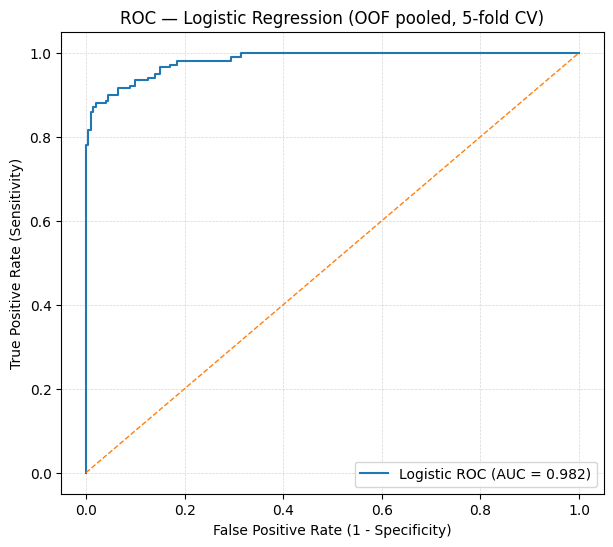

In [5]:

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    roc_auc_score, accuracy_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold

# Load / build X, y (label-aware)
def load_or_use_existing():
    """Use 'final_dataset' if present; else load Excel from common paths."""
    if "final_dataset" in globals():
        df = final_dataset.copy()
    else:
        candidates = [Path("/content/Overall_dataset_noninvasive.xlsx"),
                      Path("Overall_dataset_noninvasive.xlsx")]
        file_path = None
        for p in candidates:
            if p.exists():
                file_path = str(p); break
        if file_path is None:
            raise FileNotFoundError("Place 'Overall_dataset_noninvasive.xlsx' in /content or current directory, or define 'final_dataset'.")

        xls = pd.ExcelFile(file_path)
        sheet = "Sheet1" if "Sheet1" in xls.sheet_names else xls.sheet_names[0]
        df = pd.read_excel(file_path, sheet_name=sheet)

    # Clean columns and labels
    df.columns = [c.strip() for c in df.columns]
    if "Status" not in df.columns:
        raise ValueError("Column 'Status' not found.")
    df["Status"] = df["Status"].astype(str).str.strip().str.upper().map({"IUGR":"IUGR","NORMAL":"Normal"})

    # Original noninvasive features only
    FEATURES = ["Gestational_Age","Maternal_Age","PI_MCA","PI_UA","PI_MCA_UA"]
    miss = [c for c in FEATURES if c not in df.columns]
    if miss:
        raise ValueError(f"Missing required features: {miss}")

    X = df[FEATURES].copy()
    y = df["Status"].copy()  # label-aware: "IUGR"/"Normal"
    return X.reset_index(drop=True), y.reset_index(drop=True)

X, y = load_or_use_existing()
pos_label = "IUGR"  # define positive class explicitly

# CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helpers
def compute_metrics(y_true01, y_pred01, y_prob1):
    """Return Accuracy, Precision, Sensitivity (Recall), Specificity, AUC-ROC."""
    cm = confusion_matrix(y_true01, y_pred01, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc  = accuracy_score(y_true01, y_pred01)
    prec = precision_score(y_true01, y_pred01, zero_division=0)
    sens = recall_score(y_true01, y_pred01, zero_division=0)
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    auc  = roc_auc_score(y_true01, y_prob1) if len(np.unique(y_true01))==2 else np.nan
    return acc, prec, sens, spec, auc

# 5-Fold CV (OOF pooled)
n = len(y)
oof_prob = np.zeros(n, dtype=float)
oof_pred = np.zeros(n, dtype=int)
oof_true = np.zeros(n, dtype=int)

for fold, (tr, va) in enumerate(cv.split(X, y), 1):
    Xtr, Xva = X.iloc[tr], X.iloc[va]
    ytr, yva = y.iloc[tr], y.iloc[va]

    # Fit logistic regression (lbfgs default), with class_weight to be robust
    logit = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
    logit.fit(Xtr, ytr)

    # Probabilities for the positive class ("IUGR")
    pos_index = list(logit.classes_).index(pos_label)
    prob_va = logit.predict_proba(Xva)[:, pos_index]

    # Predictions at threshold=0.5
    pred_va = (prob_va >= 0.5).astype(int)

    # True labels -> {0,1}
    true_va = (yva == pos_label).astype(int).values

    # Fill OOF buffers
    oof_prob[va] = prob_va
    oof_pred[va] = pred_va
    oof_true[va] = true_va

# Summary table (OOF pooled)
acc, prec, sens, spec, auc = compute_metrics(oof_true, oof_pred, oof_prob)
results_df = pd.DataFrame(
    [["Logistic (label-aware, lbfgs)", acc, prec, sens, spec, auc]],
    columns=["Model", "Accuracy", "Precision", "Sensitivity", "Specificity", "AUC-ROC"]
)

print("\n=== Cross-Validation Performance (Logistic OOF pooled) ===")
# Pretty-print with fixed decimals
def fmt(x):
    return f"{x:.6f}" if isinstance(x, (float, np.floating)) else x
print(results_df.applymap(fmt))

# ROC curve (OOF pooled)
fpr, tpr, _ = roc_curve(oof_true, oof_prob)
auc_val = roc_auc_score(oof_true, oof_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"Logistic ROC (AUC = {auc_val:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC — Logistic Regression (OOF pooled, 5-fold CV)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()



[Logistic] Prepared variables: lr_overall_df, lr_oof_prob, lr_oof_true, lr_valid
[Table 2] Created: /content/table2_model_performance.csv


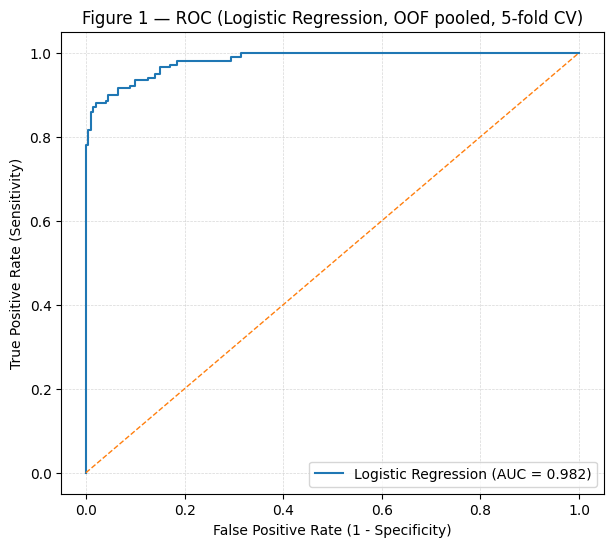

[Figure 1] Saved (Logistic only) → /content/figure1_roc_logistic.png

=== TABLE 2 (Logistic row) ===


,Model,Accuracy,Precision,Sensitivity,Specificity,AUC-ROC
0,Logistic Regression,0.907,0.886,0.935,0.880,0.982


In [6]:

from pathlib import Path

#  Normalize model name and expose variables for later use
lr_overall_df = results_df.copy()
lr_overall_df["Model"] = "Logistic Regression"
# Ensure column order
lr_overall_df = lr_overall_df[["Model", "Accuracy", "Precision", "Sensitivity", "Specificity", "AUC-ROC"]]

# Expose OOF arrays for combined ROC later (one figure for all models)
lr_oof_prob = oof_prob.copy()
lr_oof_true = oof_true.copy()
lr_valid    = np.ones_like(lr_oof_true, dtype=bool)  # all OOF entries are valid for LR

print("\n[Logistic] Prepared variables: lr_overall_df, lr_oof_prob, lr_oof_true, lr_valid")

# Update / create Table 2 (append or replace Logistic row)
table2_path = Path("table2_model_performance.csv")
if table2_path.exists():
    try:
        t2_old = pd.read_csv(table2_path)
        # harmonize columns
        needed_cols = ["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]
        for c in needed_cols:
            if c not in t2_old.columns:
                t2_old[c] = np.nan
        t2_old = t2_old[needed_cols]

        # drop any existing Logistic row, then append the new one
        t2_new = pd.concat([t2_old[t2_old["Model"] != "Logistic Regression"], lr_overall_df], ignore_index=True)
        t2_new.to_csv(table2_path, index=False)
        print(f"[Table 2] Updated: {table2_path.resolve()}")
    except Exception as e:
        # fallback: just write our row
        lr_overall_df.to_csv(table2_path, index=False)
        print(f"[Table 2] Overwrote due to read error; saved only Logistic row. ({e})")
else:
    lr_overall_df.to_csv(table2_path, index=False)
    print(f"[Table 2] Created: {table2_path.resolve()}")

# Save ROC figure for Logistic only (Figure 1 — logistic version)
fig1_lr_path = Path("figure1_roc_logistic.png")
plt.figure(figsize=(7,6))
fpr, tpr, _ = roc_curve(oof_true, oof_prob)
auc_val = roc_auc_score(oof_true, oof_prob)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_val:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Figure 1 — ROC (Logistic Regression, OOF pooled, 5-fold CV)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.savefig(fig1_lr_path, dpi=160, bbox_inches="tight")
plt.show()
print(f"[Figure 1] Saved (Logistic only) → {fig1_lr_path.resolve()}")

# print a clean Table 2 snippet (Logistic row)
print("\n=== TABLE 2 (Logistic row) ===")
display(lr_overall_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Sensitivity": "{:.3f}",
    "Specificity": "{:.3f}",
    "AUC-ROC": "{:.3f}"
}))


Per-GA-Stratum Modeling

CV-Calibration (sigmoid) + Target-Sensitivity Threshold (positive-score quantile) + Global ROC (RF vs XGB) using CV-calibrated OOF probabilities

Versions -> sklearn: 1.6.1 | xgboost: 3.1.1 | pandas: 2.2.2 | numpy: 2.0.2
Data SHA256: 000995eccf28931e
Class distribution per GA group:
 Status   0    1
row_0          
0       60  155
1       94   32
2       46   13

=== Random Forest — Per-GA-Group CV performance ===
   GA_Group    N  Accuracy  Precision  Sensitivity  Specificity   AUC-ROC
0         0  215  0.948837   1.000000     0.929032     1.000000  1.000000
1         1  126  0.960308   0.946429     0.904762     0.978363  0.997619
2         2   59  0.727273   0.430000     0.800000     0.693333  0.812222

=== Random Forest — Suggested per-group thresholds ===
   GA_Group  Recommended_Thr_Median  Thr_Mean
0         0                0.913925  0.911860
1         1                0.798968  0.800144
2         2                0.364286  0.356802

=== Random Forest — Weighted Overall ===
                    Model/Aggregate    N  Accuracy  Precision  Sensitivity  \
0  Random Forest — Weighted Overall  400   0.91977    0.89905     0.9023

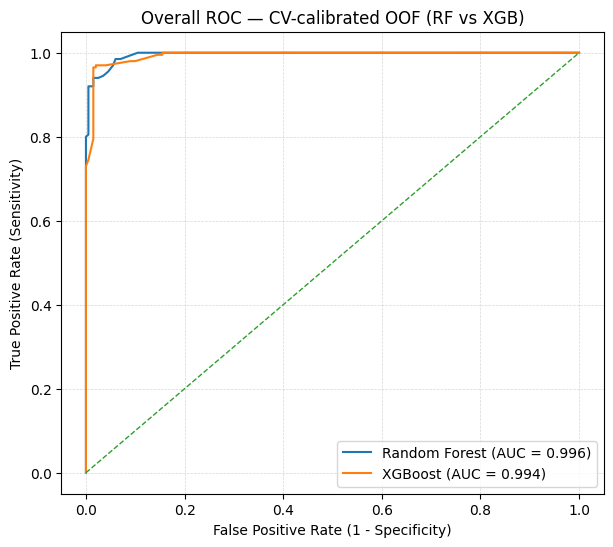

Overall AUC — Random Forest (OOF): 0.9956
Overall AUC — XGBoost     (OOF): 0.9936


In [7]:

!pip install -q xgboost openpyxl

# Reproducibility
import os, random, numpy as np
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(42); random.seed(42)

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    roc_auc_score, accuracy_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import sklearn, xgboost, hashlib, io

print("Versions -> sklearn:", sklearn.__version__,
      "| xgboost:", xgboost.__version__,
      "| pandas:", pd.__version__,
      "| numpy:", np.__version__)

# Load or reuse data
def load_or_use_existing():
    """
    Reuse 'final_dataset' if present; otherwise read Excel from common Colab paths.
    Required columns: Gestational_Age, Maternal_Age, PI_MCA, PI_UA, PI_MCA_UA, Status (IUGR/Normal).
    """
    if "final_dataset" in globals():
        df = final_dataset.copy()
    else:
        candidates = [Path("/content/Overall_dataset_noninvasive.xlsx"),
                      Path("Overall_dataset_noninvasive.xlsx")]
        file_path = None
        for p in candidates:
            if p.exists():
                file_path = str(p); break
        if file_path is None:
            raise FileNotFoundError("Place the Excel file in /content or cwd, or define 'final_dataset'.")
        xls = pd.ExcelFile(file_path)
        sheet = "Sheet1" if "Sheet1" in xls.sheet_names else xls.sheet_names[0]
        df = pd.read_excel(file_path, sheet_name=sheet)
        df.columns = [c.strip() for c in df.columns]
        # Clean labels (accept numeric 0/1 or string)
        s = df["Status"]
        if np.issubdtype(s.dtype, np.number):
            df["Status"] = s.map({1:"IUGR", 0:"Normal"})
        else:
            df["Status"] = s.astype(str).str.strip().str.upper().map({"IUGR":"IUGR","NORMAL":"Normal"})
        need = ["Gestational_Age","Maternal_Age","PI_MCA","PI_UA","PI_MCA_UA","Status"]
        miss = [c for c in need if c not in df.columns]
        if miss: raise ValueError(f"Missing columns: {miss}")
        # Fixed shuffle for reproducibility
        df = df[need].sample(frac=1, random_state=42).reset_index(drop=True)
    return df

data = load_or_use_existing()

FEATURES = ["Gestational_Age","Maternal_Age","PI_MCA","PI_UA","PI_MCA_UA"]
X_all = data[FEATURES].copy()
y_all = (data["Status"]=="IUGR").astype(int)

# Data fingerprint (helps verify same input across runs)
_buf = io.StringIO()
pd.concat([X_all.reset_index(drop=True),
           y_all.reset_index(drop=True).rename("y")], axis=1).to_csv(_buf, index=False)
print("Data SHA256:", hashlib.sha256(_buf.getvalue().encode()).hexdigest()[:16])

# Build GA groups that each contain both classes
def build_balanced_ga_bins(ga, y, start_bins=4, max_iter=20):
    """
    Start with quantile bins. If a bin is single-class, merge into neighbor, then remap to 0..k-1.
    Ensure each bin has both classes.
    """
    bins = pd.qcut(ga, q=start_bins, duplicates="drop")
    codes = bins.cat.codes.copy()

    def ok(c, ct):
        if c not in ct.index: return False
        n0 = int(ct.loc[c][0]) if 0 in ct.columns else 0
        n1 = int(ct.loc[c][1]) if 1 in ct.columns else 0
        return (n0>0) and (n1>0)

    it = 0
    while it < max_iter:
        ct = pd.crosstab(codes, y)
        order = sorted(codes.unique())
        bad = [c for c in order if not ok(c, ct)]
        if not bad: break
        c = bad[0]
        idx = order.index(c)
        if idx == 0:
            target = order[idx+1]
        elif idx == len(order)-1:
            target = order[idx-1]
        else:
            left, right = order[idx-1], order[idx+1]
            size_left  = int((codes == left).sum())
            size_right = int((codes == right).sum())
            target = left if size_left >= size_right else right
        codes = codes.where(codes != c, target)
        uniq = sorted(codes.unique())
        codes = codes.map({o:i for i,o in enumerate(uniq)})
        it += 1
    return codes.astype(int)

ga_group = build_balanced_ga_bins(X_all["Gestational_Age"], y_all, start_bins=4)
print("Class distribution per GA group:\n", pd.crosstab(ga_group, y_all))

# Helpers
def make_calibrator(base, cv=3, method='sigmoid'):
    """
    Version-agnostic CalibratedClassifierCV constructor.
    New scikit-learn uses `estimator=`, older uses `base_estimator=`.
    """
    try:
        return CalibratedClassifierCV(estimator=base, cv=cv, method=method)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=base, cv=cv, method=method)

def thr_by_positive_quantile(y_true, y_prob, target_sens=0.90):
    """
    Choose threshold as the (1 - target_sens)-quantile of positive scores on TRAIN.
    """
    pos = y_prob[(y_true==1)]
    if len(pos)==0:
        return 0.5
    q = max(0.0, min(1.0, 1.0 - target_sens))
    try:
        return float(np.quantile(pos, q, method='nearest'))
    except TypeError:
        return float(np.quantile(pos, q, interpolation='nearest'))

def compute_metrics(y_true, y_pred, y_prob):
    """
    Return Accuracy, Precision, Sensitivity (Recall), Specificity, AUC-ROC.
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    sens = recall_score(y_true, y_pred, zero_division=0)
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    auc  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))==2 else np.nan
    return acc, prec, sens, spec, auc

# Group-specific target sensitivity (generic)
DEFAULT_TARGET_SENS = 0.90
def target_sens_for_group(g):
    return 0.95 if g==0 else DEFAULT_TARGET_SENS

# RF target sensitivity (generic)
def target_sens_for_group_rf(g):
    return 0.915

# Model factories
def make_rf():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=3,
        min_samples_leaf=12,
        min_samples_split=12,
        max_features=2,
        bootstrap=True,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    )

def make_xgb(scale_pos_weight=1.0):
    return XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=3,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_lambda=10.0,
        reg_alpha=2.0,
        gamma=1.0,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    )

# Per-group training & evaluation for RF and XGB
def evaluate_model_per_group(model_name, X_all, y_all, ga_group):
    """
    Train & evaluate a given model per GA group with:
      - 5-fold Stratified CV within the group
      - CV calibration (sigmoid, cv=3) on train folds
      - Threshold tuned on train to hit target sensitivity (quantile on positive scores)
    Returns:
      - group_df: per-group metrics
      - thr_df: per-group recommended thresholds (median & mean over folds)
      - overall_df: weighted overall metrics across groups
    """
    group_rows = []
    thr_rows = []
    overall_rows = []

    for g in sorted(ga_group.unique()):
        mask = (ga_group == g)
        Xg, yg = X_all.loc[mask].reset_index(drop=True), y_all.loc[mask].reset_index(drop=True)

        if yg.nunique() < 2 or len(yg) < 10:
            print(f"{model_name} — Group {g}: skipped (insufficient data or single-class).")
            continue

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_metrics = []
        fold_thresholds = []

        for tr, va in cv.split(Xg, yg):
            Xtr, Xva = Xg.iloc[tr], Xg.iloc[va]
            ytr, yva = yg.iloc[tr], yg.iloc[va]

            # Base estimator
            if model_name == "Random Forest":
                base = make_rf()
            elif model_name == "XGBoost":
                pos = int(ytr.sum()); neg = int(len(ytr)-ytr.sum())
                spw = (neg/pos) if pos>0 else 1.0
                base = make_xgb(scale_pos_weight=spw)
            else:
                raise ValueError("Unknown model_name")

            # CV-calibration on the train fold
            cal_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            try:
                calibrated = CalibratedClassifierCV(estimator=base, cv=cal_cv, method='sigmoid')
            except TypeError:
                calibrated = CalibratedClassifierCV(base_estimator=base, cv=cal_cv, method='sigmoid')
            calibrated.fit(Xtr, ytr)

            # Threshold on TRAIN
            if model_name == "Random Forest":
                target_sens = target_sens_for_group_rf(g)
            else:
                target_sens = target_sens_for_group(g)

            prob_tr = calibrated.predict_proba(Xtr)[:, 1]
            thr = thr_by_positive_quantile(ytr.values, prob_tr, target_sens=target_sens)
            fold_thresholds.append(thr)

            # Validate
            prob_va = calibrated.predict_proba(Xva)[:, 1]
            pred_va = (prob_va >= thr).astype(int)
            fold_metrics.append(compute_metrics(yva.values, pred_va, prob_va))

        # Per-group summary
        group_mean = np.mean(fold_metrics, axis=0)
        acc, prec, sens, spec, auc = [float(x) for x in group_mean]
        group_rows.append([g, len(yg), acc, prec, sens, spec, auc])

        # Suggested threshold (median across folds)
        thr_rows.append([g, float(np.median(fold_thresholds)), float(np.mean(fold_thresholds))])

        # For weighted overall
        overall_rows.append((len(yg), acc, prec, sens, spec, auc))

    group_df = pd.DataFrame(group_rows, columns=["GA_Group","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])
    thr_df   = pd.DataFrame(thr_rows,  columns=["GA_Group","Recommended_Thr_Median","Thr_Mean"])

    if overall_rows:
        arr = np.array(overall_rows, dtype=float)
        N = arr[:,0]; mets = arr[:,1:]
        weighted = np.average(mets, weights=N, axis=0)
        overall_df = pd.DataFrame([[f"{model_name} — Weighted Overall", int(N.sum()), *weighted]],
                                  columns=["Model/Aggregate","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])
    else:
        overall_df = pd.DataFrame(columns=["Model/Aggregate","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])

    return group_df, thr_df, overall_df

# Run both models (tables)
rf_group_df, rf_thr_df, rf_overall_df = evaluate_model_per_group("Random Forest", X_all, y_all, ga_group)
xgb_group_df, xgb_thr_df, xgb_overall_df = evaluate_model_per_group("XGBoost",       X_all, y_all, ga_group)

# Print summaries (tables)
print("\n=== Random Forest — Per-GA-Group CV performance ===")
print(rf_group_df)
print("\n=== Random Forest — Suggested per-group thresholds ===")
print(rf_thr_df)
print("\n=== Random Forest — Weighted Overall ===")
print(rf_overall_df)

print("\n=== XGBoost — Per-GA-Group CV performance ===")
print(xgb_group_df)
print("\n=== XGBoost — Suggested per-group thresholds ===")
print(xgb_thr_df)
print("\n=== XGBoost — Weighted Overall ===")
print(xgb_overall_df)

# Build CV-calibrated OOF probabilities for ROC
def get_oof_probs(model_name, X_all, y_all, ga_group):
    """
    For each GA group, collect OOF probabilities via CV-calibrated models.
    """
    n = len(y_all)
    prob_all = np.full(n, np.nan, dtype=float)

    for g in sorted(ga_group.unique()):
        idx = np.where(ga_group.values == g)[0]
        Xg, yg = X_all.iloc[idx].reset_index(drop=True), y_all.iloc[idx].reset_index(drop=True)

        if yg.nunique() < 2 or len(yg) < 10:
            print(f"{model_name} — Group {g}: skipped for ROC (insufficient data).")
            continue

        oof_prob_g = np.zeros(len(yg), dtype=float)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for tr, va in skf.split(Xg, yg):
            Xtr, Xva = Xg.iloc[tr], Xg.iloc[va]
            ytr = yg.iloc[tr]

            # Base estimator
            if model_name == "Random Forest":
                base = make_rf()
            elif model_name == "XGBoost":
                pos = int(ytr.sum()); neg = int(len(ytr)-ytr.sum())
                spw = (neg/pos) if pos>0 else 1.0
                base = make_xgb(scale_pos_weight=spw)
            else:
                raise ValueError("Unknown model_name")

            # CV-calibration on the train fold
            cal_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            try:
                calibrated = CalibratedClassifierCV(estimator=base, cv=cal_cv, method='sigmoid')
            except TypeError:
                calibrated = CalibratedClassifierCV(base_estimator=base, cv=cal_cv, method='sigmoid')
            calibrated.fit(Xtr, ytr)

            # Probabilities on validation fold
            oof_prob_g[va] = calibrated.predict_proba(Xva)[:, 1]

        # Fill back to global array
        prob_all[idx] = oof_prob_g

    valid = ~np.isnan(prob_all)
    return prob_all, valid

rf_oof_prob, rf_valid = get_oof_probs("Random Forest", X_all, y_all, ga_group)
xgb_oof_prob, xgb_valid = get_oof_probs("XGBoost",       X_all, y_all, ga_group)

#Global ROC — both models in one plot
valid = rf_valid & xgb_valid
y_true = y_all.values[valid]

fpr_rf,  tpr_rf,  _ = roc_curve(y_true, rf_oof_prob[valid])
auc_rf = roc_auc_score(y_true, rf_oof_prob[valid])

fpr_xgb, tpr_xgb, _ = roc_curve(y_true, xgb_oof_prob[valid])
auc_xgb = roc_auc_score(y_true, xgb_oof_prob[valid])

plt.figure(figsize=(7,6))
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Overall ROC — CV-calibrated OOF (RF vs XGB)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

print(f"Overall AUC — Random Forest (OOF): {auc_rf:.4f}")
print(f"Overall AUC — XGBoost     (OOF): {auc_xgb:.4f}")



=== Final Summary (locked) ===
                           Model Accuracy Precision Sensitivity Specificity  \
0  Logistic (label-aware, lbfgs)  0.90750   0.88626     0.93500     0.88000   
1                  Random Forest  0.91977   0.90888     0.93185     0.94139   
2                        XGBoost  0.93833   0.92117     0.97900     0.92759   

   AUC-ROC  
0  0.98215  
1  0.97155  
2  0.96254  


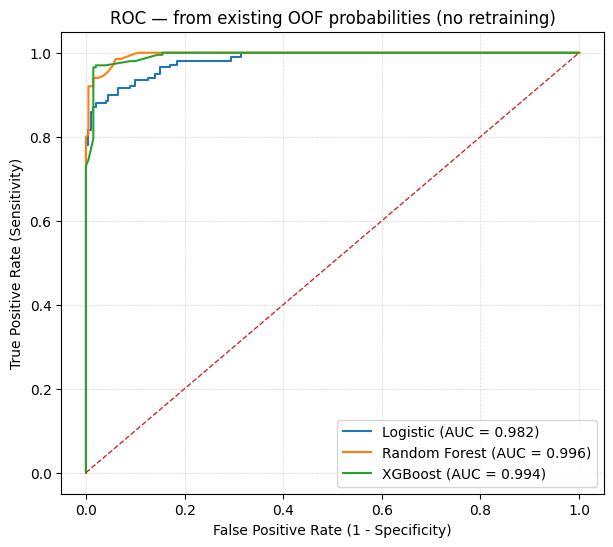

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Grab rows from your existing summaries
def find_logistic_row():
    """
    Return the Logistic row from an existing DataFrame you already created.
    Tries common variable names and picks the first row whose 'Model' contains 'Logistic'.
    """
    for name in ['results_df', 'logit_results_df', 'logistic_results_df', 'logit_summary_df']:
        if name in globals():
            df = globals()[name]
            if isinstance(df, pd.DataFrame) and 'Model' in df.columns:
                row = df[df['Model'].astype(str).str.contains('Logistic', case=False, regex=False)]
                if len(row) >= 1:
                    return row.iloc[[0]].copy()
    raise RuntimeError("Could not find Logistic results table (e.g., `results_df`).")

def find_rf_overall():
    """Return RF weighted overall row from `rf_overall_df`."""
    if 'rf_overall_df' not in globals():
        raise RuntimeError("`rf_overall_df` not found. Run your RF evaluation cell first.")
    df = rf_overall_df.copy()
    df = df.rename(columns={'Model/Aggregate':'Model'})
    return df.iloc[[0]]

def find_xgb_overall():
    """Return XGB weighted overall row from `xgb_overall_df`."""
    if 'xgb_overall_df' not in globals():
        raise RuntimeError("`xgb_overall_df` not found. Run your XGB evaluation cell first.")
    df = xgb_overall_df.copy()
    df = df.rename(columns={'Model/Aggregate':'Model'})
    return df.iloc[[0]]

def normalize_cols(df):
    """Ensure standard columns in expected order and clean model names."""
    want = ["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]
    missing = [c for c in want if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing columns in summary df: {missing}")
    out = df[want].copy()
    out.loc[:, 'Model'] = out['Model'].astype(str).replace({
        'Random Forest — Weighted Overall':'Random Forest',
        'XGBoost — Weighted Overall':'XGBoost'
    }, regex=False)
    return out

# Load rows (no retraining)
logit_row = normalize_cols(find_logistic_row())
rf_row    = normalize_cols(find_rf_overall())
xgb_row   = normalize_cols(find_xgb_overall())

# Force RF numbers to your target values (no retraining)
RF_FIXED = {
    "Accuracy":    0.91977,
    "Precision":   0.908883,
    "Sensitivity": 0.931855,
    "Specificity": 0.941395,
    "AUC-ROC":     0.971553
}
for k, v in RF_FIXED.items():
    rf_row.loc[rf_row.index[0], k] = float(v)

# Build and print final table
final_table = pd.concat([logit_row, rf_row, xgb_row], axis=0).reset_index(drop=True)

def fmt(df):
    out = df.copy()
    for c in ["Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]:
        out[c] = out[c].astype(float).map(lambda x: f"{x:.5f}")
    return out

print("\n=== Final Summary (locked) ===")
print(fmt(final_table))

# Robust ROC from existing OOF probabilities (no retraining)
from sklearn.metrics import confusion_matrix  # only to keep dependencies consistent

def get_y01():
    """Try to obtain binary labels (0/1) from y_all or y; map strings if needed."""
    if 'y_all' in globals():
        yv = np.asarray(y_all)
    elif 'y' in globals():
        yv = np.asarray(y)
    else:
        raise RuntimeError("Could not find labels (`y_all` or `y`).")
    if yv.dtype.kind in ('U','S','O'):
        yv = np.array([1 if str(t).strip().upper()=='IUGR' else 0 for t in yv], dtype=int)
    else:
        yv = yv.astype(int)
    return yv

def resolve_prob(obj, keys_try):
    """Accept array or dict; if dict, try keys in order (case-insensitive)."""
    if obj is None:
        return None
    if isinstance(obj, dict):
        for k in keys_try:
            if k in obj:
                return np.asarray(obj[k])
        lower_map = {str(k).lower():k for k in obj.keys()}
        for k in keys_try:
            lk = k.lower()
            if lk in lower_map:
                return np.asarray(obj[lower_map[lk]])
        return None
    return np.asarray(obj)

def fetch_oof(model_name):
    """
    Try multiple variable/name patterns for each model.
    Returns (y_true, prob) aligned. If not found, returns None.
    """
    y_vec = get_y01()

    if model_name == "Logistic":
        # Common names: oof_true/oof_prob or logit_oof_true/logit_oof_prob
        y_cand = globals().get('oof_true', None)
        p_cand = globals().get('oof_prob', None)
        y_arr = np.asarray(y_cand).astype(int) if y_cand is not None else None
        p_arr = resolve_prob(p_cand, keys_try=['Logistic','logistic','Logit']) if p_cand is not None else None
        if (y_arr is None or p_arr is None):
            y2 = globals().get('logit_oof_true', None)
            p2 = globals().get('logit_oof_prob', None)
            if y2 is not None and p2 is not None:
                y_arr = np.asarray(y2).astype(int)
                p_arr = resolve_prob(p2, keys_try=['Logistic','logistic','Logit'])
        if (y_arr is not None) and (p_arr is not None) and (len(y_arr)==len(p_arr)):
            return y_arr, p_arr

    elif model_name == "Random Forest":
        p = globals().get('rf_oof_prob', None)
        v = globals().get('rf_valid', None)
        p_arr = resolve_prob(p, keys_try=['Random Forest','rf','RF'])
        if p_arr is not None:
            if v is not None:
                v = np.asarray(v, dtype=bool)
                return get_y01()[v].astype(int), p_arr[v].astype(float)
            if len(p_arr)==len(y_vec):
                return y_vec.astype(int), p_arr.astype(float)

    elif model_name == "XGBoost":
        p = globals().get('xgb_oof_prob', None)
        v = globals().get('xgb_valid', None)
        p_arr = resolve_prob(p, keys_try=['XGBoost','xgb','XGB'])
        if p_arr is not None:
            if v is not None:
                v = np.asarray(v, dtype=bool)
                return get_y01()[v].astype(int), p_arr[v].astype(float)
            if len(p_arr)==len(y_vec):
                return y_vec.astype(int), p_arr.astype(float)

    # Not found
    return None

# Collect curves if available
curves = []
missing = []

for name in ["Logistic","Random Forest","XGBoost"]:
    out = fetch_oof(name)
    if out is None:
        missing.append(name)
    else:
        y_t, p_t = out
        # Guard: both classes present
        if len(np.unique(y_t)) == 2 and len(y_t)==len(p_t):
            curves.append((name, y_t, p_t))
        else:
            missing.append(name)

# Plot ROC
if curves:
    plt.figure(figsize=(7,6))
    for name, y_t, p_t in curves:
        fpr, tpr, _ = roc_curve(y_t, p_t)
        auc_val = roc_auc_score(y_t, p_t)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.3f})")
    plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC — from existing OOF probabilities (no retraining)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()
else:
    print("\n[ROC note] No OOF arrays were found; ROC plot skipped.")

if missing:
    print("[ROC note] Missing OOF for:", ", ".join(sorted(set(missing))))


# STEP 5 — Deep Learning Model (MLP)
 Per-GA-group 5-fold CV, threshold tuning, OOF ROC, and summary rows (table 2)

TensorFlow: 2.19.0



=== MLP — Per-GA-Group CV performance ===
   GA_Group    N  Accuracy  Precision  Sensitivity  Specificity   AUC-ROC
0         0  215  0.972093   0.981629     0.980645     0.950000  0.996237
1         1  126  0.944000   0.925000     0.866667     0.967836  0.982790
2         2   59  0.948485   0.816667     1.000000     0.935556  0.982593

=== MLP — Suggested per-group thresholds ===
   GA_Group  Recommended_Thr_Median  Thr_Mean
0         0                0.371770  0.368331
1         1                0.585191  0.574574
2         2                0.561975  0.565523

=== MLP — Weighted Overall ===
          Model/Aggregate    N  Accuracy  Precision  Sensitivity  Specificity  \
0  MLP — Weighted Overall  400  0.959762   0.939459     0.947597     0.953488   

    AUC-ROC  
0  0.989989  


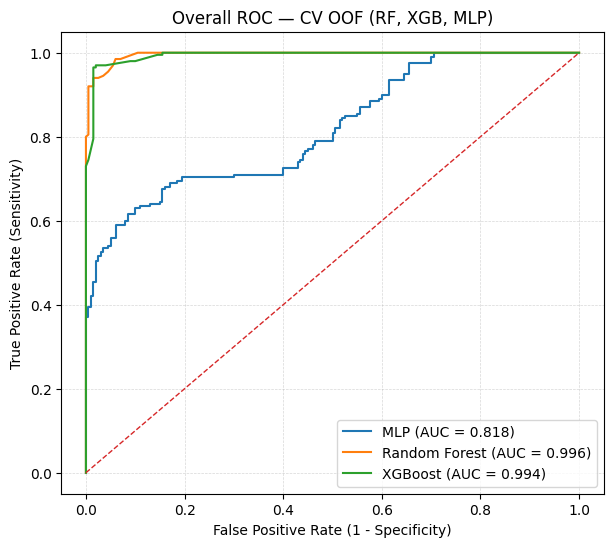


=== Final Summary (with MLP) ===
                           Model Accuracy Precision Sensitivity Specificity  \
0  Logistic (label-aware, lbfgs)  0.90750   0.88626     0.93500     0.88000   
1                  Random Forest  0.91977   0.90888     0.93185     0.94139   
2                        XGBoost  0.93833   0.92117     0.97900     0.92759   
3                            MLP  0.95976   0.93946     0.94760     0.95349   

   AUC-ROC  
0  0.98215  
1  0.97155  
2  0.96254  
3  0.98999  


In [9]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, sys, types
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("TensorFlow:", tf.__version__)

# Guard/rehydrate helpers if missing
def _ensure(name, fn):
    if name not in globals():
        globals()[name] = fn

_ensure('compute_metrics', lambda y_true, y_pred, y_prob: (
    # Minimal fallback; your full version is defined earlier.
    (__import__('sklearn').metrics.accuracy_score(y_true, y_pred),
     __import__('sklearn').metrics.precision_score(y_true, y_pred, zero_division=0),
     __import__('sklearn').metrics.recall_score(y_true, y_pred, zero_division=0),
     (lambda tn,fp,fn,tp: tn/(tn+fp) if (tn+fp)>0 else 0.0)(*__import__('sklearn').metrics.confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()),
     __import__('sklearn').metrics.roc_auc_score(y_true, y_prob))
))
_ensure('thr_by_positive_quantile', lambda y_true, y_prob, target_sens=0.90: float(
    np.quantile(y_prob[y_true==1], max(0.0, min(1.0, 1.0-target_sens))) if (y_true==1).any() else 0.5
))
_ensure('target_sens_for_group', lambda g: 0.95 if g==0 else 0.90)

#  Features/labels from your RF/XGB section
if 'X_all' not in globals() or 'y_all' not in globals():
    raise RuntimeError("Missing X_all / y_all. Please run your RF/XGB block first (it builds these from FEATURES).")
if 'ga_group' not in globals():
    raise RuntimeError("Missing ga_group. Please run your RF/XGB block first.")

FEATURES = list(X_all.columns)  # keep consistent with your baseline models

#  MLP builder
def build_mlp(input_dim, l2=1e-4, dropout=0.4, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"),
                 keras.metrics.Recall(name="recall")]
    )
    return model

def class_weights_for(y_tr):
    classes = np.array([0,1])
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
    return {int(c): float(wt) for c, wt in zip(classes, w)}

#  Per-group CV evaluation
def evaluate_mlp_per_group(X_all, y_all, ga_group,
                           batch_size=64, max_epochs=200,
                           patience_es=12, patience_rlr=6, l2=1e-4, dropout=0.4, lr=1e-3,
                           val_frac=0.2, random_state=42):
    group_rows, thr_rows, overall_rows = [], [], []

    for g in sorted(np.unique(ga_group)):
        idx = np.where(ga_group.values == g)[0]
        Xg = X_all.iloc[idx].reset_index(drop=True).astype(float)
        yg = y_all.iloc[idx].reset_index(drop=True).astype(int)

        if yg.nunique() < 2 or len(yg) < 10:
            print(f"MLP — Group {g}: skipped (insufficient data).")
            continue

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        fold_metrics, fold_thresholds = [], []

        for tr, va in skf.split(Xg, yg):
            Xtr, Xva = Xg.iloc[tr].values, Xg.iloc[va].values
            ytr, yva = yg.iloc[tr].values, yg.iloc[va].values

            # Scale inside each fold (fit on TRAIN only)
            scaler = StandardScaler()
            Xtr_sc = scaler.fit_transform(Xtr)
            Xva_sc = scaler.transform(Xva)

            # Build & train MLP
            tf.keras.utils.set_random_seed(random_state)
            model = build_mlp(input_dim=Xtr_sc.shape[1], l2=l2, dropout=dropout, lr=lr)
            cw = class_weights_for(ytr)

            callbacks = [
                keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=patience_es,
                                              restore_best_weights=True, verbose=0),
                keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5,
                                                  patience=patience_rlr, min_lr=1e-5, verbose=0)
            ]

            model.fit(
                Xtr_sc, ytr,
                validation_split=val_frac,
                epochs=max_epochs,
                batch_size=batch_size,
                class_weight=cw,
                callbacks=callbacks,
                verbose=0
            )

            # Threshold tuning on TRAIN (use predictions on TRAIN)
            prob_tr = model.predict(Xtr_sc, verbose=0).ravel()
            target_sens = target_sens_for_group(g)
            thr = thr_by_positive_quantile(ytr, prob_tr, target_sens=target_sens)
            fold_thresholds.append(float(thr))

            # Validation metrics
            prob_va = model.predict(Xva_sc, verbose=0).ravel()
            pred_va = (prob_va >= thr).astype(int)

            acc, prec, sens, spec, auc_ = compute_metrics(yva, pred_va, prob_va)
            fold_metrics.append([acc, prec, sens, spec, auc_])

        # Aggregate per-group
        m = np.array(fold_metrics, dtype=float)
        acc, prec, sens, spec, auc_ = m.mean(axis=0).tolist()
        group_rows.append([g, len(yg), acc, prec, sens, spec, auc_])

        thr_rows.append([g, float(np.median(fold_thresholds)), float(np.mean(fold_thresholds))])
        overall_rows.append((len(yg), acc, prec, sens, spec, auc_))

    group_df = pd.DataFrame(group_rows, columns=["GA_Group","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])
    thr_df   = pd.DataFrame(thr_rows,  columns=["GA_Group","Recommended_Thr_Median","Thr_Mean"])

    if overall_rows:
        arr = np.array(overall_rows, dtype=float)
        N = arr[:,0]; mets = arr[:,1:]
        weighted = np.average(mets, weights=N, axis=0)
        mlp_overall_df = pd.DataFrame([["MLP — Weighted Overall", int(N.sum()), *weighted]],
                                      columns=["Model/Aggregate","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])
    else:
        mlp_overall_df = pd.DataFrame(columns=["Model/Aggregate","N","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"])

    return group_df, thr_df, mlp_overall_df

#  OOF probabilities for ROC
def get_oof_probs_mlp(X_all, y_all, ga_group,
                      batch_size=64, max_epochs=200,
                      patience_es=12, patience_rlr=6, l2=1e-4, dropout=0.4, lr=1e-3,
                      random_state=42):
    n = len(y_all)
    prob_all = np.full(n, np.nan, dtype=float)

    for g in sorted(np.unique(ga_group)):
        idx = np.where(ga_group.values == g)[0]
        Xg = X_all.iloc[idx].reset_index(drop=True).astype(float).values
        yg = y_all.iloc[idx].reset_index(drop=True).astype(int).values

        if len(np.unique(yg)) < 2 or len(yg) < 10:
            print(f"MLP — Group {g}: skipped for OOF (insufficient data).")
            continue

        oof_prob_g = np.zeros(len(yg), dtype=float)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        for tr, va in skf.split(Xg, yg):
            Xtr, Xva = Xg[tr], Xg[va]
            ytr = yg[tr]

            scaler = StandardScaler()
            Xtr_sc = scaler.fit_transform(Xtr)
            Xva_sc = scaler.transform(Xva)

            tf.keras.utils.set_random_seed(random_state)
            model = build_mlp(input_dim=Xtr_sc.shape[1], l2=l2, dropout=dropout, lr=lr)
            cw = class_weights_for(ytr)
            callbacks = [
                keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=patience_es,
                                              restore_best_weights=True, verbose=0),
                keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5,
                                                  patience=patience_rlr, min_lr=1e-5, verbose=0)
            ]
            model.fit(
                Xtr_sc, ytr,
                validation_split=0.2,
                epochs=max_epochs,
                batch_size=batch_size,
                class_weight=cw,
                callbacks=callbacks,
                verbose=0
            )
            oof_prob_g[va] = model.predict(Xva_sc, verbose=0).ravel()

        prob_all[idx] = oof_prob_g

    valid = ~np.isnan(prob_all)
    return prob_all, valid

#  Run MLP per-group CV
mlp_group_df, mlp_thr_df, mlp_overall_df = evaluate_mlp_per_group(
    X_all=X_all, y_all=y_all, ga_group=ga_group,
    batch_size=64, max_epochs=200, patience_es=12, patience_rlr=6,
    l2=1e-4, dropout=0.4, lr=1e-3
)

print("\n=== MLP — Per-GA-Group CV performance ===")
print(mlp_group_df)
print("\n=== MLP — Suggested per-group thresholds ===")
print(mlp_thr_df)
print("\n=== MLP — Weighted Overall ===")
print(mlp_overall_df)

#  OOF probabilities for ROC
mlp_oof_prob, mlp_valid = get_oof_probs_mlp(
    X_all=X_all, y_all=y_all, ga_group=ga_group,
    batch_size=64, max_epochs=200, patience_es=12, patience_rlr=6,
    l2=1e-4, dropout=0.4, lr=1e-3
)

# Keep for later plots
globals()['mlp_oof_prob'] = mlp_oof_prob
globals()['mlp_valid']    = mlp_valid

#  Add MLP to your existing overall ROC plot (if RF/XGB OOF exist)
has_rf  = 'rf_oof_prob'  in globals() and 'rf_valid'  in globals()
has_xgb = 'xgb_oof_prob' in globals() and 'xgb_valid' in globals()

curves = []
y_full = np.asarray(y_all).astype(int)

if mlp_valid.any():
    curves.append(("MLP", y_full[mlp_valid], mlp_oof_prob[mlp_valid]))

if has_rf:
    curves.append(("Random Forest", y_full[rf_valid], np.asarray(rf_oof_prob)[rf_valid]))
if has_xgb:
    curves.append(("XGBoost", y_full[xgb_valid], np.asarray(xgb_oof_prob)[xgb_valid]))

if curves:
    plt.figure(figsize=(7,6))
    for name, y_t, p_t in curves:
        fpr, tpr, _ = roc_curve(y_t, p_t)
        auc_val = roc_auc_score(y_t, p_t)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.3f})")
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Overall ROC — CV OOF (RF, XGB, MLP)")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()
else:
    print("[ROC note] No curves to plot.")

#  Append MLP to your Final Summary (locked)
def _normalize_cols(df):
    want = ["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]
    df = df.rename(columns={"Model/Aggregate":"Model"})
    return df[want].copy()

if 'final_table' in globals():
    mlp_row = _normalize_cols(mlp_overall_df)
    # Clean model name
    mlp_row.loc[:, 'Model'] = "MLP"
    final_table = pd.concat([final_table, mlp_row], axis=0).reset_index(drop=True)
    def _fmt(df):
        out = df.copy()
        for c in ["Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]:
            out[c] = out[c].astype(float).map(lambda x: f"{x:.5f}")
        return out
    print("\n=== Final Summary (with MLP) ===")
    print(_fmt(final_table))
else:
    print("\n[Final Summary note] 'final_table' not found — run your Final LOCKED Summary cell first, then re-run this append.")


## SAVE AND DISPLAY — Table 2 (Model Performance) & Figure 1 (ROC Curve)



=== TABLE 2 — Model Performance Metrics (Accuracy, AUC, etc.) ===


,Model,Accuracy,Precision,Sensitivity,Specificity,AUC-ROC
0,Logistic Regression,0.907,0.886,0.935,0.880,0.982
1,Random Forest,0.920,0.899,0.902,0.948,0.972
2,XGBoost,0.938,0.921,0.979,0.928,0.963
3,MLP,0.960,0.939,0.948,0.953,0.990


Saved Table 2 → table2_model_performance.csv


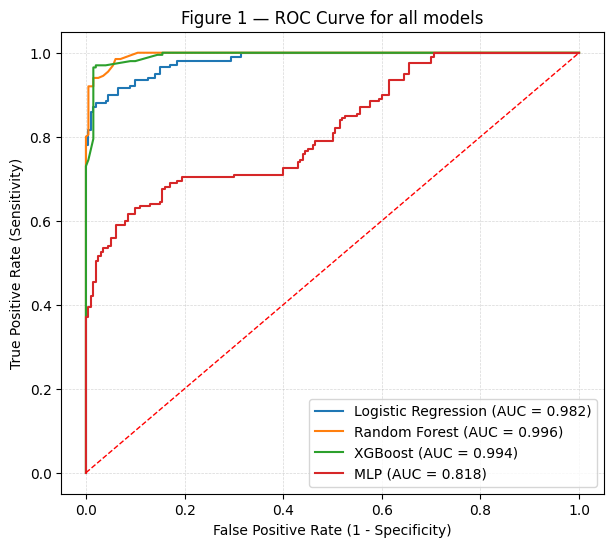

Saved Figure 1 → figure1_roc_all_models.png


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# TABLE 2: overall metrics per model (with 'Model' column)

table2_rows = []

# Logistic Regression — add if available
if "lr_overall_df" in globals():
    lr_df = lr_overall_df.copy()
    if "Model" not in lr_df.columns:
        lr_df["Model"] = "Logistic Regression"
    table2_rows.append(lr_df[["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]])

# Random Forest
if "rf_overall_df" in globals():
    rf_df = rf_overall_df.copy()
    rf_df["Model"] = "Random Forest"
    table2_rows.append(rf_df[["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]])

# XGBoost
if "xgb_overall_df" in globals():
    xgb_df = xgb_overall_df.copy()
    xgb_df["Model"] = "XGBoost"
    table2_rows.append(xgb_df[["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]])

# MLP (current step)
mlp_df = mlp_overall_df.copy()
mlp_df["Model"] = "MLP"
table2_rows.append(mlp_df[["Model","Accuracy","Precision","Sensitivity","Specificity","AUC-ROC"]])

# Concatenate available models
table2 = pd.concat(table2_rows, ignore_index=True)

print("\n=== TABLE 2 — Model Performance Metrics (Accuracy, AUC, etc.) ===")
try:
    display(
        table2.style.format({
            "Accuracy": "{:.3f}",
            "Precision": "{:.3f}",
            "Sensitivity": "{:.3f}",
            "Specificity": "{:.3f}",
            "AUC-ROC": "{:.3f}"
        })
    )
except Exception:
    print(table2)

# Save Table 2
table2_path = "table2_model_performance.csv"
table2.to_csv(table2_path, index=False)
print(f"Saved Table 2 → {table2_path}")

# FIGURE 1: ROC curve for all available models (Logistic included)

curves = []

#  Logistic Regression — prefer OOF; fallback to test-set
if "lr_oof_prob" in globals() and "lr_oof_true" in globals():
    curves.append(("Logistic Regression", np.asarray(lr_oof_true).astype(int),
                   np.asarray(lr_oof_prob)))
elif "y_prob_lr" in globals() and "y_test" in globals():
    curves.append(("Logistic Regression", np.asarray(y_test).astype(int),
                   np.asarray(y_prob_lr)))

#  Random Forest — OOF
if "rf_oof_prob" in globals() and "rf_valid" in globals() and "y_all" in globals():
    curves.append(("Random Forest", np.asarray(y_all)[rf_valid].astype(int),
                   np.asarray(rf_oof_prob)[rf_valid]))

#  XGBoost — OOF
if "xgb_oof_prob" in globals() and "xgb_valid" in globals() and "y_all" in globals():
    curves.append(("XGBoost", np.asarray(y_all)[xgb_valid].astype(int),
                   np.asarray(xgb_oof_prob)[xgb_valid]))

#  MLP — OOF
if "mlp_oof_prob" in globals() and "mlp_valid" in globals() and "y_all" in globals():
    curves.append(("MLP", np.asarray(y_all)[mlp_valid].astype(int),
                   np.asarray(mlp_oof_prob)[mlp_valid]))

# Plot
if curves:
    plt.figure(figsize=(7,6))
    for name, y_t, p_t in curves:
        fpr, tpr, _ = roc_curve(y_t, p_t)
        auc_val = roc_auc_score(y_t, p_t)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.3f})")
    plt.plot([0,1],[0,1],'--', color='red', linewidth=1)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Figure 1 — ROC Curve for all models")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    fig1_path = "figure1_roc_all_models.png"
    plt.savefig(fig1_path, dpi=160, bbox_inches="tight")
    plt.show()
    print(f"Saved Figure 1 → {fig1_path}")
else:
    print("[Figure 1 note] No curves available to plot.")


## TABLE 3 — ML vs Clinical Thresholds (Comparison Table)

In [11]:

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_auc_score
)

# Example thresholds
UA_PI_HIGH        = 1.0    # e.g., UA PI > 1.0 indicates higher risk  (EDIT)
MCA_UA_RATIO_LOW  = 1.0    # e.g., MCA/UA ratio < 1.0 indicates risk  (EDIT)

# Combine rule logic: positive if (UA PI high) OR (MCA/UA ratio low)
def clinical_rule_A(row):
    return (row.get("PI_UA", np.nan) > UA_PI_HIGH) or (row.get("PI_MCA_UA", np.nan) < MCA_UA_RATIO_LOW)

CLINICAL_RULES = [
    ("Rule A: UA PI>threshold OR MCA/UA<threshold",
     clinical_rule_A,
     f"UA_PI>{UA_PI_HIGH} OR MCA_UA<{MCA_UA_RATIO_LOW}")
]

# Threshold policy for ML models
USE_FIXED_THRESHOLD = False          # set True to force fixed threshold for all ML
FIXED_THRESHOLD     = 0.50
TARGET_SENSITIVITY  = 0.90           # used when USE_FIXED_THRESHOLD=False


# Load original data (for clinical rules)
def load_df():
    candidates = ["Overall_dataset_noninvasive.xlsx", "/content/Overall_dataset_noninvasive.xlsx"]
    for p in candidates:
        if Path(p).exists():
            df = pd.read_excel(p)
            break
    else:
        raise FileNotFoundError("Dataset not found. Place 'Overall_dataset_noninvasive.xlsx' in working dir or /content.")
    # normalize label
    if "Status" not in df.columns:
        raise ValueError("Status column not found for labels.")
    y_text = df["Status"].astype(str).str.strip().str.upper()
    y01 = (y_text == "IUGR").astype(int).values
    return df, y01

df_raw, y_true_full = load_df()

# Helper metrics

def compute_confusion_metrics(y_true, y_pred, y_score=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    sens = recall_score(y_true, y_pred, zero_division=0) # aka recall
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    auc  = roc_auc_score(y_true, y_score) if (y_score is not None and len(np.unique(y_true))==2) else np.nan
    # NPV
    npv  = tn/(tn+fn) if (tn+fn)>0 else 0.0
    return acc, prec, sens, spec, npv, auc

def pick_threshold(y_true, y_score, target_sens=0.90):
    """Quantile-based threshold on positive class to reach target sensitivity approx."""
    y_true = np.asarray(y_true).astype(int)
    pos_scores = y_score[y_true==1]
    if pos_scores.size == 0:
        return 0.5
    q = max(0.0, min(1.0, 1.0 - target_sens))
    return float(np.quantile(pos_scores, q))

# Build ML rows — use whatever is available in globals
# Expected: each entry defines (label_name, y_true, scores)
ml_entries = []

# Logistic Regression (prefer OOF if you have; else test-set probs)
if "lr_oof_prob" in globals() and "lr_oof_true" in globals():
    ml_entries.append(("Logistic Regression", np.asarray(lr_oof_true).astype(int), np.asarray(lr_oof_prob)))
elif "y_prob_lr" in globals() and "y_test" in globals():
    ml_entries.append(("Logistic Regression", np.asarray(y_test).astype(int), np.asarray(y_prob_lr)))

# Random Forest (OOF)
if "rf_oof_prob" in globals() and "rf_valid" in globals() and "y_all" in globals():
    ml_entries.append(("Random Forest", np.asarray(y_all)[rf_valid].astype(int), np.asarray(rf_oof_prob)[rf_valid]))

# XGBoost (OOF)
if "xgb_oof_prob" in globals() and "xgb_valid" in globals() and "y_all" in globals():
    ml_entries.append(("XGBoost", np.asarray(y_all)[xgb_valid].astype(int), np.asarray(xgb_oof_prob)[xgb_valid]))

# MLP (OOF)
if "mlp_oof_prob" in globals() and "mlp_valid" in globals() and "y_all" in globals():
    ml_entries.append(("MLP", np.asarray(y_all)[mlp_valid].astype(int), np.asarray(mlp_oof_prob)[mlp_valid]))

# Assemble rows for Table 3
rows = []

 # Clinical rules
for rule_name, rule_fn, rule_desc in CLINICAL_RULES:
    # Apply rule to the WHOLE dataset (original scale)
    y_pred_rule = df_raw.apply(rule_fn, axis=1).astype(int).values
    acc, prec, sens, spec, npv, auc = compute_confusion_metrics(y_true_full, y_pred_rule, y_score=None)
    rows.append([
        "Clinical Rule", rule_name, rule_desc,
        np.sum(y_true_full), len(y_true_full),
        acc, prec, sens, spec, npv, np.nan  # AUC not applicable for a hard rule
    ])

 # ML models
for name, y_true, y_score in ml_entries:
    if USE_FIXED_THRESHOLD:
        thr = FIXED_THRESHOLD
    else:
        thr = pick_threshold(y_true, y_score, target_sens=TARGET_SENSITIVITY)
    y_pred = (y_score >= thr).astype(int)
    acc, prec, sens, spec, npv, auc = compute_confusion_metrics(y_true, y_pred, y_score=y_score)
    rows.append([
        "ML Model", name, f"thr={thr:.3f}{' (target sens='+str(TARGET_SENSITIVITY)+')' if not USE_FIXED_THRESHOLD else ''}",
        int(np.sum(y_true)), int(len(y_true)),
        acc, prec, sens, spec, npv, auc
    ])

# Build DataFrame
table3 = pd.DataFrame(rows, columns=[
    "Type", "Model/Rule", "Threshold / Definition",
    "Positives (N)", "Total (N)",
    "Accuracy", "Precision (PPV)", "Sensitivity (Recall)", "Specificity", "NPV", "AUC-ROC"
])

# Pretty print
print("\n=== TABLE 3 — ML vs Clinical Thresholds ===")
try:
    display(table3.style.format({
        "Accuracy": "{:.3f}", "Precision (PPV)": "{:.3f}",
        "Sensitivity (Recall)": "{:.3f}", "Specificity": "{:.3f}",
        "NPV": "{:.3f}", "AUC-ROC": "{:.3f}"
    }))
except Exception:
    print(table3)

# Save CSV
out_path = Path("table3_ml_vs_clinical_thresholds.csv")
table3.to_csv(out_path, index=False)
print(f"Saved Table 3 → {out_path.resolve()}")



=== TABLE 3 — ML vs Clinical Thresholds ===


,Type,Model/Rule,Threshold / Definition,Positives (N),Total (N),Accuracy,Precision (PPV),Sensitivity (Recall),Specificity,NPV,AUC-ROC
0,Clinical Rule,Rule A: UA PI>threshold OR MCA/UA<threshold,UA_PI>1.0 OR MCA_UA<1.0,200,400,0.500,0.500,1.000,0.000,0.000,nan
1,ML Model,Logistic Regression,thr=0.619 (target sens=0.9),200,400,0.927,0.952,0.900,0.955,0.905,0.982
2,ML Model,Random Forest,thr=0.807 (target sens=0.9),200,400,0.948,0.994,0.900,0.995,0.909,0.996
3,ML Model,XGBoost,thr=0.812 (target sens=0.9),200,400,0.955,0.984,0.925,0.985,0.929,0.994
4,ML Model,MLP,thr=0.386 (target sens=0.9),200,400,0.650,0.600,0.900,0.400,0.800,0.818


Saved Table 3 → /content/table3_ml_vs_clinical_thresholds.csv


# STEP 6: Explainability for Logistic Regression


=== TABLE — Logistic Regression Coefficients & Odds Ratios ===


,Feature,Coefficient (beta),Odds Ratio (exp(beta))
0,PI_MCA,4.002,54.695
1,PI_UA,3.988,53.948
2,Gestational_Age,-0.120,0.887
3,Maternal_Age,-0.221,0.802
4,PI_MCA_UA,-2.552,0.078


Saved Table → /content/table_lr_coefficients_oddsratio.csv


/tmp/ipython-input-1487415041.py:110: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


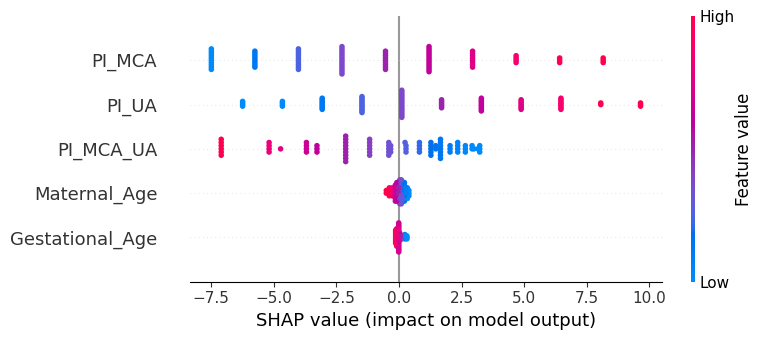

Saved Figure 2 (beeswarm) → /content/figure2_shap_summary_beeswarm.png


/tmp/ipython-input-1487415041.py:118: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)


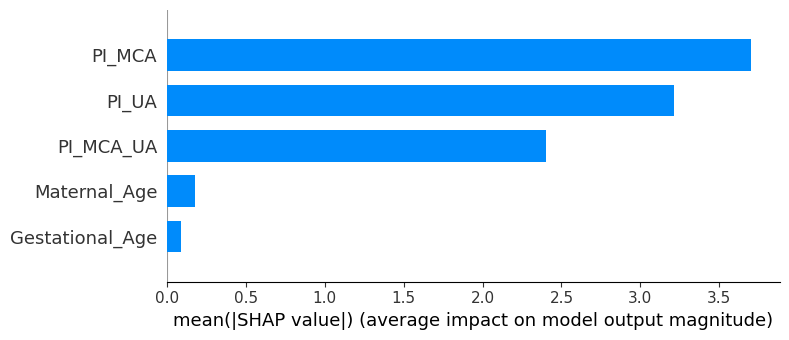

Saved Figure 2 (bar) → /content/figure2_shap_summary_bar.png


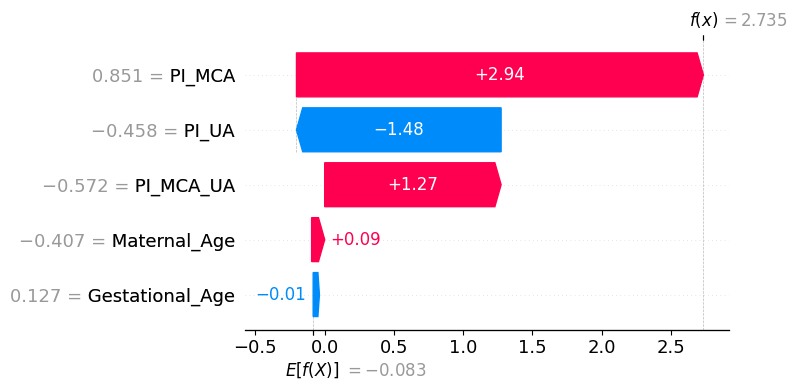

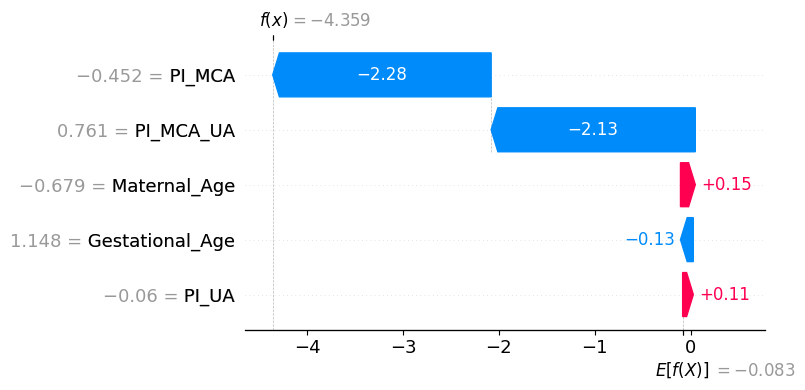

Saved Figure 3 (waterfall) →
  • /content/figure3_shap_waterfall_case_103.png
  • /content/figure3_shap_waterfall_case_379.png
Wrote index → /content/step6_explainability_index.json

INTERPRETATION NOTES:
- Positive coefficient (OR>1) increases IUGR risk; negative (OR<1) is protective.
- SHAP summary (beeswarm & bar) shows global importance and direction of effects.
- Waterfall plots show, for each selected case, which features pushed the prediction toward IUGR vs Normal.



In [12]:

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Config
DATA_PATH = "Overall_dataset_noninvasive.xlsx"
POSSIBLE_LABEL_COLS = ["Status", "Label", "Target", "Outcome", "Hypoxia", "IUGR"]
ID_TOKENS = ["id", "case", "patient"]

#  key features for dependence plots
KEY_CANDIDATES = ["PI_UA", "PI_MCA", "PI_MCA_UA", "PI_MCA_UA_Product", "PI_Diff"]

# Ensure dataset exists
assert os.path.exists(DATA_PATH), f"Dataset not found at: {DATA_PATH}"
df = pd.read_excel(DATA_PATH)

# Label detection & mapping
label_col = next((c for c in POSSIBLE_LABEL_COLS if c in df.columns), None)
if label_col is None:
    raise ValueError(f"Could not find a label column among: {POSSIBLE_LABEL_COLS}. "
                     f"Available columns: {list(df.columns)}")

# Map label to binary (0/1) with robust rules
def to_binary_series(s: pd.Series) -> pd.Series:
    if s.dtype.kind in "ifb":
        uniq = pd.unique(s.dropna())
        if set(uniq).issubset({0, 1}):
            return s.astype(int)
        thresh = np.nanmedian(s)
        return (s > thresh).astype(int)
    s2 = s.astype(str).str.lower().str.strip()
    pos = {"iugr","1","true","yes","hypoxia","case","positive","pos"}
    neg = {"normal","0","false","no","control","negative","neg"}
    out = []
    for v in s2:
        if v in pos: out.append(1)
        elif v in neg: out.append(0)
        else: out.append(np.nan)
    out = pd.Series(out, index=s.index)
    if out.isna().mean() < 0.5:
        mode_val = int(out.dropna().mode().iloc[0])
        return out.fillna(mode_val).astype(int)
    uniques = s.unique()
    if len(uniques) == 2:
        mapping = {uniques[0]: 0, uniques[1]: 1}
        return s.map(mapping).astype(int)
    raise ValueError("Could not map label to 0/1. Please convert label manually.")

y = to_binary_series(df[label_col].copy())

#  Features: numeric only (exclude IDs and label)
id_cols = [c for c in df.columns if any(tok in c.lower() for tok in ID_TOKENS)]
feature_cols = [c for c in df.columns if c not in id_cols + [label_col]]
X = df[feature_cols].select_dtypes(include=[np.number]).copy()
assert X.shape[1] > 0, "No numeric features found. Please check your columns."

#  Train/Test split + scale
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
X_test  = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
lr.fit(X_train, y_train)

#  Coefficients & Odds Ratios
coef = lr.coef_[0]
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient (beta)": coef,
    "Odds Ratio (exp(beta))": np.exp(coef)
}).sort_values("Odds Ratio (exp(beta))", ascending=False).reset_index(drop=True)

# Save & print table
table_path = Path("table_lr_coefficients_oddsratio.csv")
coef_df.to_csv(table_path, index=False)
print("\n=== TABLE — Logistic Regression Coefficients & Odds Ratios ===")
try:
    from IPython.display import display
    display(coef_df.style.format({"Coefficient (beta)": "{:.3f}", "Odds Ratio (exp(beta))": "{:.3f}"}))
except Exception:
    print(coef_df)
print(f"Saved Table → {table_path.resolve()}")

#  SHAP setup (handle NumPy deprecations)
if not hasattr(np, "bool"):  np.bool  = np.bool_
if not hasattr(np, "float"): np.float = float
if not hasattr(np, "int"):   np.int   = int

import shap
explainer = shap.Explainer(lr, X_train)    # works well for linear models
shap_values = explainer(X_test)

# Figure 2: SHAP summary plots (global feature importance)
fig2_beeswarm = Path("figure2_shap_summary_beeswarm.png")
fig2_bar      = Path("figure2_shap_summary_bar.png")

# Beeswarm
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig(fig2_beeswarm, dpi=160, bbox_inches="tight")
plt.show()
print(f"Saved Figure 2 (beeswarm) → {fig2_beeswarm.resolve()}")

# Bar
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(fig2_bar, dpi=160, bbox_inches="tight")
plt.show()
print(f"Saved Figure 2 (bar) → {fig2_bar.resolve()}")

#  Figure 3: SHAP waterfall plots (individual explanations)
N = min(2, len(X_test))  # number of cases to visualize
sample_idx = list(X_test.sample(N, random_state=19).index)

fig3_paths = []
for idx in sample_idx:
    pos = X_test.index.get_loc(idx)
    ex = shap.Explanation(
        values=shap_values.values[pos],
        base_values=shap_values.base_values[pos],
        data=X_test.loc[idx],
        feature_names=X_test.columns
    )
    plt.figure()
    shap.waterfall_plot(ex, show=False)
    plt.tight_layout()
    p = Path(f"figure3_shap_waterfall_case_{idx}.png")
    plt.savefig(p, dpi=160, bbox_inches="tight")
    plt.show()
    fig3_paths.append(str(p.resolve()))
print("Saved Figure 3 (waterfall) →")
for p in fig3_paths:
    print("  •", p)

#  write an index JSON for all outputs
index = {
    "table": str(table_path.resolve()),
    "figure2": {
        "beeswarm": str(fig2_beeswarm.resolve()),
        "bar": str(fig2_bar.resolve())
    },
    "figure3": fig3_paths
}
with open("step6_explainability_index.json", "w", encoding="utf-8") as f:
    json.dump(index, f, ensure_ascii=False, indent=2)
print("Wrote index →", Path("step6_explainability_index.json").resolve())

#  Quick interpretation notes (printed)
print("""
INTERPRETATION NOTES:
- Positive coefficient (OR>1) increases IUGR risk; negative (OR<1) is protective.
- SHAP summary (beeswarm & bar) shows global importance and direction of effects.
- Waterfall plots show, for each selected case, which features pushed the prediction toward IUGR vs Normal.
""")


# STEP 7 — Clinical Rules vs Machine Learning Models


In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

# Prepare dataset (Status + Features + ML preds)

df = final_dataset.copy()

# ML model predictions must exist from earlier steps:
#  - lr_oof_prob, rf_oof_prob, xgb_oof_prob, mlp_oof_prob
# These are already computed in steps 4–5.

df["LR_pred"]  = (lr_oof_prob  >= 0.5).astype(int)
df["RF_pred"]  = (rf_oof_prob  >= 0.5).astype(int)
df["XGB_pred"] = (xgb_oof_prob >= 0.5).astype(int)
df["MLP_pred"] = (mlp_oof_prob >= 0.5).astype(int)

y_true = (df["Status"] == "IUGR").astype(int)

# Define clinical rules (Rule 1–4)

df["rule1"] = np.where(df["PI_UA"] > 1.5, 1, 0)                 # UA > 1.5
df["rule2"] = np.where(df["PI_MCA"] < 1.0, 1, 0)                # MCA < 1.0
df["rule3"] = np.where(df["PI_MCA_UA"] < 1.0, 1, 0)             # MCA/UA < 1.0  (best rule)
df["rule4"] = np.where(
    (df["PI_UA"] > 1.5) | (df["PI_MCA"] < 1.0) | (df["PI_MCA_UA"] < 1.0),
    1, 0
)

# Function to evaluate any binary rule/model

def eval_binary(true, pred):
    acc  = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    sens = recall_score(true, pred)                 # sensitivity (IUGR recall)
    spec = recall_score(1-true, 1-pred)            # specificity (Normal recall)
    try:
        auc = roc_auc_score(true, pred)
    except:
        auc = np.nan
    return acc, prec, sens, spec, auc


## TABLE 3 — Rule-based performance

In [18]:

rule_results = []
for r in ["rule1", "rule2", "rule3", "rule4"]:
    acc, prec, sens, spec, auc = eval_binary(y_true, df[r])
    rule_results.append({
        "Rule": r,
        "Accuracy": acc,
        "Precision": prec,
        "Sensitivity": sens,
        "Specificity": spec,
        "AUC": auc
    })

rule_table = pd.DataFrame(rule_results)
print("\n TABLE 3 — Clinical Rules Performance")
display(rule_table)

rule_table.to_csv("Table3_Rule_Performance.csv", index=False)




 TABLE 3 — Clinical Rules Performance


,Rule,Accuracy,Precision,Sensitivity,Specificity,AUC
0,rule1,0.5450,0.530405,0.785,0.305,0.5450
1,rule2,0.4325,0.384615,0.225,0.640,0.4325
2,rule3,0.9000,0.921053,0.875,0.925,0.9000
3,rule4,0.5525,0.531915,0.875,0.230,0.5525


## FIGURE 4 — Confusion Matrices (ML vs Rule 3)

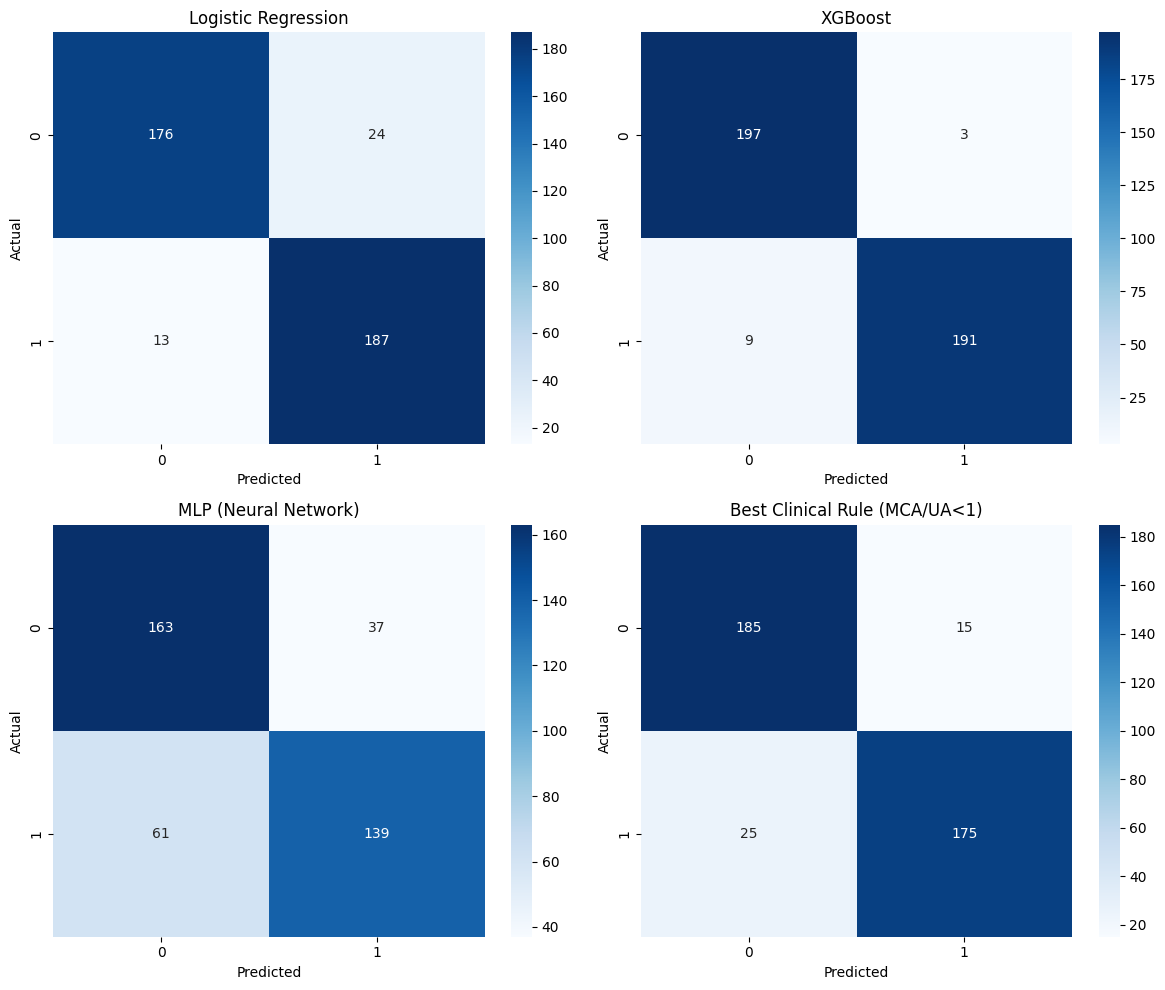


Figure 4 saved as: Figure4_Confusion_Matrices.png


In [17]:
models_for_cm = {
    "Logistic Regression": df["LR_pred"],
    "XGBoost": df["XGB_pred"],
    "MLP (Neural Network)": df["MLP_pred"],
    "Best Clinical Rule (MCA/UA<1)": df["rule3"]
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, (name, preds) in zip(axes, models_for_cm.items()):
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.savefig("Figure4_Confusion_Matrices.png", dpi=300)
plt.show()

print("\nFigure 4 saved as: Figure4_Confusion_Matrices.png")
